

```
# Выбран кодовый формат
```

# Домашнее задание 2. Поисковая система для документов

**Модуль 2. Классический поиск и рекуррентные архитектуры**

**ФИО студента: Кузнецов Кирилл Игоревич**

**Дата выполнения: 17 сентября 2025**

## Описание задания

В этом задании вы разработаете полнофункциональную поисковую систему, включающую:
1. **Предобработку корпуса.**
2. **BM25.**
3. **Векторный поиск** — на основе эмбеддингов.
4. **Гибридный поиск** — комбинация BM25 и векторного поиска.
5. **Выбор метрики и оценку качества** — для конкретной задачи.

---

## Установка и импорт библиотек

In [1]:
# # Установка необходимых библиотек
# !pip install sentence-transformers
# !pip install faiss-cpu
# !pip install rank-bm25  # для сравнения
# !pip install pymorphy3 pymorphy3-dicts-ru
# !pip install tqdm
# !pip install matplotlib seaborn
# !pip install pandas numpy

In [1]:
import pathlib
import re
import math
import time
from typing import List, Dict, Tuple, Optional, Set
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

# Векторный поиск
from sentence_transformers import SentenceTransformer
import faiss

# BM25
from rank_bm25 import BM25Okapi

# Создание директорий
for dir_name in ['data', 'indices', 'models', 'results', 'tests']:
    pathlib.Path(dir_name).mkdir(exist_ok=True)

# Загрузка NLTK ресурсов
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Инициализация морфологического анализатора
morph = pymorphy3.MorphAnalyzer()


---

## Часть 1. Подготовка данных

1. Загрузите и изучите предложенный датасет.  
2. Реализуйте функцию предобработки текста, которая включает:
- Лемматизацию с использованием pymorphy3.
- Удаление стоп-слов и пунктуации.  
3. Обработайте весь корпус документов и сохраните результат для последующих шагов.  


In [2]:
from datasets import load_dataset

# Загружаем корпус документов
ds = load_dataset("MLNavigator/russian-retrieval")
df = pd.DataFrame(ds['train'])
questions_df = df[['text','q']]


# Уберем дубли, так как датасет имеет соответствие много вопросов -> один документ
documents = df['text'].drop_duplicates().to_list()


Статистика корпуса:
Средняя длина документа: 100.6 слов
Медианная длина: 91.0 слов
Мин/Макс: 41/1041 слов


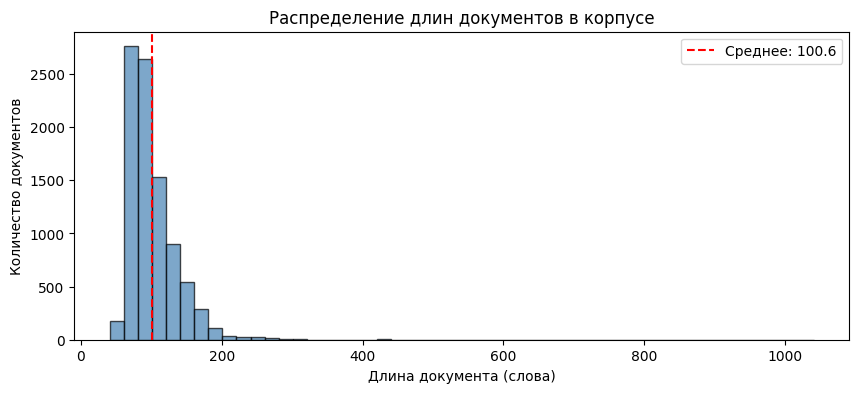

In [3]:
# Базовая статистика
doc_lengths = [len(doc.split()) for doc in documents]
print(f"\nСтатистика корпуса:")
print(f"Средняя длина документа: {np.mean(doc_lengths):.1f} слов")
print(f"Медианная длина: {np.median(doc_lengths):.1f} слов")
print(f"Мин/Макс: {min(doc_lengths)}/{max(doc_lengths)} слов")

# Визуализация распределения длин
plt.figure(figsize=(10, 4))
plt.hist(doc_lengths, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Длина документа (слова)')
plt.ylabel('Количество документов')
plt.title('Распределение длин документов в корпусе')
plt.axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Среднее: {np.mean(doc_lengths):.1f}')
plt.legend()
plt.show()

In [4]:
# 🧹 Предобработка текста - чистим, нормализуем и готовим слова для анализа или модели

class TextPreprocessor:
    """
    Класс для предобработки текста
    
    Поддерживает:
    - Лемматизацию (приведение слов к начальной форме: "бежали" → "бежать")
    - Удаление стоп-слов (типа "и", "в", "на" - они редко несут смысл)
    """

    def __init__(self, use_lemma=True, remove_stopwords=True):
        """
        - use_lemma: приводить слова к начальной форме? (полезно для ML, чтобы "коты" и "кот" считались одним словом)
        - remove_stopwords: удалять бесполезные слова вроде "это", "тот", "был"?

        """
        self.use_lemma = use_lemma
        self.remove_stopwords = remove_stopwords

        # Загружаем морфологический анализатор для русского языка, для 
        # опредения части речи, рода, число и привести к нормальной форме
        self.morph = pymorphy3.MorphAnalyzer()

        #  Загружаем список стоп-слов на русском (типа "и", "в", "что", "он")
        self.stop_words = set(stopwords.words('russian'))

    def preprocess(self, text: str) -> List[str]:
        """
        Главный метод
        
        """

        # Приводим всё к нижнему регистру
        text = text.lower()

        # Удаляем HTML-теги и ссылки 
        text = re.sub(r'<.*?>', ' ', text)      # <b></b> 
        text = re.sub(r'http\S+', ' ', text)    # https://
        text = re.sub(r'[^а-яёa-z0-9\s]', ' ', text)  # оставляем только буквы, цифры и пробелы
        text = re.sub(r'\s+', ' ', text)        # несколько пробелов 

        # 3️⃣ Разбиваем текст на токены по пробелам
        tokens = text.split()

        # Удаляем стоп-слова
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]

        # Приводим слова к нормальной форме (лемматизация)
        if self.use_lemma:
            # Для каждого слова берём первую (самую вероятную) грамматическую интерпретацию
            # и возвращаем её нормальную форму 
            tokens = [self.morph.parse(t)[0].normal_form for t in tokens]

        # Удаляем слишком короткие слова (меньше 3 символов)
        tokens = [t for t in tokens if len(t) > 2]

        # Возвращаем готовый список чистых, осмысленных слов
        return tokens


# Создаём экземпляр предобработчика
preprocessor = TextPreprocessor(use_lemma=True, remove_stopwords=True)

In [5]:
# Предобрабатываем весь корпус
print("\nПредобработка корпуса...")
tokenized_docs = [preprocessor.preprocess(doc) for doc in tqdm(documents)]

# Статистика после предобработки
vocab = set()
for doc in tokenized_docs:
    vocab.update(doc)

print(f"\nРазмер словаря: {len(vocab)} уникальных токенов")
print(f"Средняя длина документа после обработки: {np.mean([len(doc) for doc in tokenized_docs]):.1f} токенов")


Предобработка корпуса...


  0%|          | 0/9076 [00:00<?, ?it/s]


Размер словаря: 59223 уникальных токенов
Средняя длина документа после обработки: 73.9 токенов


---

## Часть 2. Реализация BM25

1. Постройте инвертированный индекс для корпуса. Индекс должен содержать частоту термина в документе (TF) и документную частоту (DF).
2. Реализуйте функцию поиска BM25 с нуля. Формула для ранжирования:

$score(D, Q) = Σ IDF(qi) * (f(qi, D) * (k1 + 1)) / (f(qi, D) + k1 * (1 - b + b * |D| / avgdl))$

3. Проведите оптимизацию гиперпараметра k1, чтобы улучшить качество поиска.

In [16]:
class InvertedIndex:
    """Инвертированный индекс для BM25"""

    def __init__(self):
        self.index = defaultdict(list)   # term -> [(doc_id, term_freq, positions)]
        self.doc_lengths = {}            # doc_id -> length
        self.doc_count = 0               # общее количество документов
        self.avg_doc_length = 0          # средняя длина документа
        self.doc_freq = defaultdict(int) # term -> количество документов с термином

    def add_document(self, doc_id: int, tokens: List[str]):
        """Добавление документа в индекс"""
        self.doc_count += 1
        self.doc_lengths[doc_id] = len(tokens)

        # Подсчёт частот и позиций терминов
        term_positions = defaultdict(list)
        term_freqs = Counter(tokens)

        for pos, term in enumerate(tokens):
            term_positions[term].append(pos)

        # Добавление в индекс
        for term, freq in term_freqs.items():
            self.index[term].append({
                'doc_id': doc_id,
                'freq': freq,
                'positions': term_positions[term]
            })
            self.doc_freq[term] += 1

    def build(self, tokenized_docs: List[List[str]]):
        """Построение индекса для корпуса документов"""
        print("Построение инвертированного индекса...")

        for doc_id, tokens in enumerate(tqdm(tokenized_docs)):
            self.add_document(doc_id, tokens)

        # Вычисляем среднюю длину документа
        self.avg_doc_length = sum(self.doc_lengths.values()) / len(self.doc_lengths)

        print(f"Индекс построен: {len(self.index)} терминов, {self.doc_count} документов")
        print(f"Средняя длина документа: {self.avg_doc_length:.2f} токенов")

    def get_posting_list(self, term: str) -> List[Dict]:
        """Получение posting list для термина"""
        return self.index.get(term, [])

    def get_stats(self) -> Dict:
        """Статистика индекса"""
        posting_lengths = [len(postings) for postings in self.index.values()]
        return {
            'total_terms': len(self.index),
            'total_docs': self.doc_count,
            'avg_doc_length': self.avg_doc_length,
            'avg_posting_length': np.mean(posting_lengths) if posting_lengths else 0,
            'max_posting_length': max(posting_lengths) if posting_lengths else 0,
            'memory_size_mb': self._estimate_memory() / (1024 * 1024)
        }

    def _estimate_memory(self) -> int:
        """Оценка использования памяти в байтах"""
        # Грубая оценка
        size = 0
        for term, postings in self.index.items():
            size += len(term) * 2  # Unicode символы
            size += len(postings) * 50  # Примерный размер posting
        return size

# Создание и построение инвертированного индекса на основе предварительно токенизированных документов
index = InvertedIndex()
index.build(tokenized_docs)

stats = index.get_stats()
print("Статистика:")
for key, value in stats.items():
    print(f"{key}: {value}")

Построение инвертированного индекса...


  0%|          | 0/9076 [00:00<?, ?it/s]

Индекс построен: 59223 терминов, 9076 документов
Средняя длина документа: 73.86 токенов
Статистика:
total_terms: 59223
total_docs: 9076
avg_doc_length: 73.86073159982371
avg_posting_length: 9.09006635935363
max_posting_length: 4074
memory_size_mb: 26.62065887451172


In [19]:
class BM25:
    """Реализация алгоритма BM25"""

    def __init__(self, index: InvertedIndex, k1: float = 1.2, b: float = 0.75):
        """
        Параметры:
        - k1: параметр насыщения частоты термина (обычно 1.2-2.0)
        - b: параметр нормализации длины документа (обычно 0.75)
        """
        self.index = index
        self.k1 = k1
        self.b = b
        self.idf_cache = {}  # Кэш для IDF значений

    def _compute_idf(self, term: str) -> float:
        """Вычисление IDF для термина"""
        if term in self.idf_cache:
            return self.idf_cache[term]

        N = self.index.doc_count
        df = self.index.doc_freq.get(term, 0)

        if df == 0:
            idf = 0
        else:
            # Формула IDF для BM25
            idf = math.log((N - df + 0.5) / (df + 0.5) + 1)

        self.idf_cache[term] = idf
        return idf

    def score(self, query_tokens: List[str], doc_id: int) -> float:
        """Вычисление BM25 скора для документа"""
        score = 0.0
        doc_length = self.index.doc_lengths.get(doc_id, 0)

        if doc_length == 0:
            return 0.0

        # Нормализация длины документа
        norm_factor = 1 - self.b + self.b * (doc_length / self.index.avg_doc_length)

        # Считаем частоты терминов в документе
        doc_term_freqs = defaultdict(int)
        for term in query_tokens:
            postings = self.index.get_posting_list(term)
            for posting in postings:
                if posting['doc_id'] == doc_id:
                    doc_term_freqs[term] = posting['freq']
                    break

        # Вычисляем скор
        for term in set(query_tokens):  # Уникальные термины запроса
            if term not in doc_term_freqs:
                continue

            idf = self._compute_idf(term)
            tf = doc_term_freqs[term]

            # Формула BM25
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * norm_factor

            score += idf * (numerator / denominator)

        return score

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Поиск top-k документов для запроса"""
        # Предобработка запроса
        query_tokens = preprocessor.preprocess(query)

        if not query_tokens:
            return []

        # Находим документы-кандидаты (содержащие хотя бы один термин)
        candidate_docs = set()
        for term in query_tokens:
            postings = self.index.get_posting_list(term)
            for posting in postings:
                candidate_docs.add(posting['doc_id'])

        # Вычисляем скоры для кандидатов
        scores = []
        for doc_id in candidate_docs:
            score = self.score(query_tokens, doc_id)
            if score > 0:
                scores.append((doc_id, score))

        # Сортируем по скору и возвращаем top-k
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

# Создаём экземпляр BM25
bm25 = BM25(index, k1=1.2, b=0.75)


In [20]:
# Реализация поиска используя BM25
k1_candidates = [0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]


def bm25_search_optimiser(k1):

    bm25 = BM25(index, k1=k1, b=0.75)

    # Тестовые запросы
    test_queries = [
        "машинное обучение",
        "нейронные сети",
        "поисковые системы BM25",
        "Python программирование"
    ]

    print(f"\nТестирование BM25 поиска на k1={k1}:")
    print("=" * 50)

    for query in test_queries:
        results = bm25.search(query, top_k=3)
        print(f"\nЗапрос: '{query}'")
        print("Топ-3 результата:")

        for doc_id, score in results:
            # Показываем начало документа
            doc_preview = documents[doc_id][:100] + "..."
            print(f"  Doc {doc_id} (score: {score:.3f}): {doc_preview}")
            

for i in k1_candidates:
    bm25_search_optimiser(i)


Тестирование BM25 поиска на k1=0.8:

Запрос: 'машинное обучение'
Топ-3 результата:
  Doc 3752 (score: 9.215): Особенность программного обеспечения состоит в том, что оно производится в одной форме — в виде исхо...
  Doc 6183 (score: 8.960): Промышленный переворот, произошедший с 60-х годов XVIII до первой четверти XIX веко́в в Великобритан...
  Doc 5764 (score: 7.383): Перево́д — деятельность по интерпретации смысла текста на одном языке (исходном языке [ИЯ]) и создан...

Запрос: 'нейронные сети'
Топ-3 результата:
  Doc 7764 (score: 16.253): Области мозга, постоянно используемые, когда человек занят вопросами морали, были исследованы качест...
  Doc 6086 (score: 6.005): Двусторонние рынки (двусторонние сети) — сетевые рынки, которые имеют две группы пользователей с воз...
  Doc 7568 (score: 5.871): Во множестве сетей пользователи являются гомогенными, то есть они выполняют одинаковые функции. Напр...

Запрос: 'поисковые системы BM25'
Топ-3 результата:
  Doc 4025 (score: 13.496): Для п

# Наблюдения:

## Скоры монотонно растут с увеличением k1.

### Например, для запроса "нейронные сети":

> k1=0.8 : Doc 7764: 16.253

> k1=2.5 : Doc 7764: 20.327

* Ранжирование (топ-3) остаётся стабильным.

* Для всех запросов топ-3 документов не меняется при изменении k1 - меняются только скоры.

* Это говорит о том, что относительная релевантность документов устойчива к k1.


---
---
## Часть 3. Векторный поиск

1. Используйте предобученную модель sentence-transformers для получения векторных представлений (эмбеддингов) всех документов.
2. Создайте индекс для быстрого поиска ближайших соседей с помощью faiss-cpu.
3. Реализуйте функцию векторного поиска, которая по запросу находит top-k наиболее близких документов.


In [28]:
# Тестовые запросы
test_queries = [
    "машинное обучение",
    "нейронные сети",
    "поисковые системы BM25",
    "Python программирование"
]

In [30]:
class VectorSearch:
    """Векторный поиск с использованием Sentence Transformers и FAISS"""

    def __init__(self, model_name: str = 'BAAI/bge-m3'):
        print(f"Загрузка модели {model_name}...")
        self.model = SentenceTransformer(model_name, device='mps')
        self.index = None
        self.documents = None
        self.doc_embeddings = None

    def build_index(self, documents: List[str]):
        """Построение векторного индекса"""
        print("Создание эмбеддингов документов...")
        self.documents = documents

        # Создаём эмбеддинги для всех документов
        self.doc_embeddings = self.model.encode(
            documents,
            show_progress_bar=True,
            convert_to_numpy=True
        )

        # Нормализуем векторы для косинусного сходства
        faiss.normalize_L2(self.doc_embeddings)

        # Создаём FAISS индекс
        dimension = self.doc_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Inner Product = Cosine similarity после нормализации
        self.index.add(self.doc_embeddings)

        print(f"Векторный индекс построен: {len(documents)} документов, размерность {dimension}")

    def search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Поиск top-k похожих документов"""
        # Создаём эмбеддинг запроса
        query_embedding = self.model.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(query_embedding)

        # Поиск в индексе
        scores, indices = self.index.search(query_embedding, top_k)

        # Возвращаем результаты в формате (doc_id, score)
        results = [(int(idx), float(score)) for idx, score in zip(indices[0], scores[0])]
        return results

In [31]:
# Создаём векторный поиск
vector_search = VectorSearch()
vector_search.build_index(documents)

Загрузка модели BAAI/bge-m3...
Создание эмбеддингов документов...


Batches:   0%|          | 0/284 [00:00<?, ?it/s]

RuntimeError: Invalid buffer size: 8.87 GiB

In [ ]:
# Тестируем
print("Тестирование векторного поиска:")
for query in test_queries:
    results = vector_search.search(query, top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        doc = documents[doc_id]
        print(f"  [{score:.3f}] {doc.title[:50]}...")

___
___

## Часть 4. Гибридный поиск

1. Разработайте функцию, которая комбинирует результаты ранжирования от BM25 и векторного поиска.
2. Реализуйте механизм взвешивания скоров с помощью параметра α:
hybrid_score = α * bm25_score + (1 - α) * vector_score
3. Проведите автоматическую оптимизацию параметра α на валидационном наборе данных.


In [ ]:
# Тестируем гибридный поиск
print("Тестирование гибридного поиска:")
for query in test_queries:
    results = hybrid_search.search(query, top_k=3)
    print(f"Запрос: '{query}'")
    for doc_id, score in results:
        doc = documents[doc_id]
        print(f"  [{score:.3f}] {doc.title[:50]}...")

---
---

## Часть 5. Оценка качества

1. Выберите и **обоснуйте метрику** для оценки качества вашей поисковой системы (например, MRR, MAP@k или NDCG@k). **Обязательно подумайте о том, какой топ-к нужно выбрать исходя из данных**.
2. **Создайте небольшой датасет для оценки**, состоящий из запросов и релевантных им документов.  
3. **Сравните качество** всех трех реализованных подходов (BM25, векторный, гибридный) на вашем датасете.  
